## 毒品隨機森林模型
1. 不處理資料不平衡分佈
2. 超參數調教
3. 計算效能指標
4. ROC_AUC Curve
5. factor importance
6. confusion matrix

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

In [2]:
plt.rcParams['font.sans-serif']=['Microsoft Jhenghei']
plt.rcParams['axes.unicode_minus']=False

### 資料讀取

In [3]:
df = pd.read_csv("../data/trainDRUG.csv", encoding="utf8")

In [4]:
df.head()

,性別,教育,神智,年齡,每月採尿平均,實際保管長度,違規次數,獎勵次數,犯次,一年內次數,二年內次數,三年內次數,四年內次數,五年內次數,首犯年齡,再犯註記
0,1,4,3,3,2.333,1,0,0,5,0,0,0,3,4,0,0
1,1,3,2,3,0.000,1,0,0,2,0,0,0,1,0,0,0
2,1,3,2,3,1.000,3,0,2,4,0,0,0,0,0,1,0
3,1,3,0,4,1.714,1,0,0,5,0,0,0,0,0,1,1
4,1,3,0,3,0.871,4,0,1,2,0,0,0,0,0,0,0


In [5]:
df.columns

Index(['性別', '教育', '神智', '年齡', '每月採尿平均', '實際保管長度', '違規次數', '獎勵次數', '犯次',
       '一年內次數', '二年內次數', '三年內次數', '四年內次數', '五年內次數', '首犯年齡', '再犯註記'],
      dtype='object')

In [6]:
df.shape

(65402, 16)

Text(0.5, 0, '再犯註記(1:再犯，0:非再犯)')

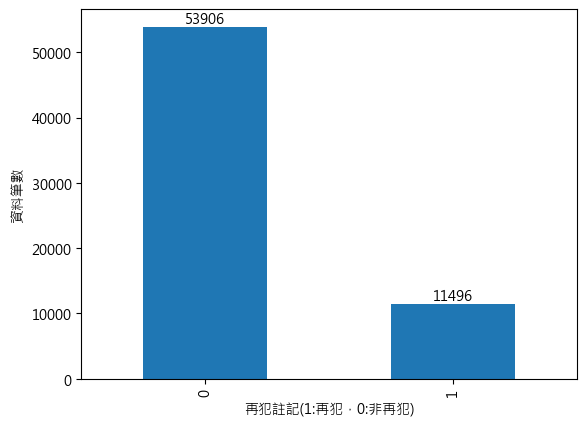

In [7]:
tgtn = df.groupby('再犯註記')
ax = tgtn.size().plot.bar()
ax.bar_label(ax.containers[0]) #顯示bar的資料數據 
ax.set_ylabel("資料筆數") #設定y軸標籤
ax.set_xlabel("再犯註記(1:再犯，0:非再犯)") #設定y軸標籤

### 建立訓練集與測試集(X, y)

In [8]:
X = df.drop(labels=['再犯註記'], axis=1).values
y = df['再犯註記'].values

In [9]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
target_names = ['非再犯','再犯']

In [11]:
# 基本模型/原始資料
model1 = RandomForestClassifier(random_state=42, n_jobs=-1)
model1.fit(train_X, train_y)
y_pred = model1.predict_proba(test_X)[:, 1]
predict_y = model1.predict(test_X)
fpr1, tpr1, _ = roc_curve(test_y, y_pred)
auc1 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))

              precision    recall  f1-score   support

         非再犯       0.86      0.96      0.91     10743
          再犯       0.60      0.26      0.36      2338

    accuracy                           0.84     13081
   macro avg       0.73      0.61      0.63     13081
weighted avg       0.81      0.84      0.81     13081



In [12]:
# RF model with balanced class weight
model2 = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
model2.fit(train_X, train_y)
y_pred = model2.predict_proba(test_X)[:, 1]
predict_y = model2.predict(test_X)
fpr2, tpr2, _ = roc_curve(test_y, y_pred)
auc2 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))

              precision    recall  f1-score   support

         非再犯       0.86      0.96      0.90     10743
          再犯       0.57      0.26      0.35      2338

    accuracy                           0.83     13081
   macro avg       0.71      0.61      0.63     13081
weighted avg       0.80      0.83      0.81     13081



In [13]:
# RF model with balanced subsample class weight
model3 = RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1)
model3.fit(train_X, train_y)
y_pred = model3.predict_proba(test_X)[:, 1]
predict_y = model3.predict(test_X)
fpr3, tpr3, _ = roc_curve(test_y, y_pred)
auc3 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))

              precision    recall  f1-score   support

         非再犯       0.86      0.96      0.90     10743
          再犯       0.58      0.26      0.36      2338

    accuracy                           0.83     13081
   macro avg       0.72      0.61      0.63     13081
weighted avg       0.81      0.83      0.81     13081



In [14]:
# RF with SMOTE
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(train_X, train_y) #X, y
model4 = RandomForestClassifier(random_state=42, n_jobs=-1)
model4.fit(X_over, y_over)
y_pred = model4.predict_proba(test_X)[:, 1]
predict_y = model4.predict(test_X)
fpr4, tpr4, _ = roc_curve(test_y, y_pred)
auc4 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))

              precision    recall  f1-score   support

         非再犯       0.86      0.93      0.90     10743
          再犯       0.52      0.33      0.40      2338

    accuracy                           0.83     13081
   macro avg       0.69      0.63      0.65     13081
weighted avg       0.80      0.83      0.81     13081



In [16]:
# RF with undersampling and oversampling 
import pickle
with open('modelfile.pkl', 'rb') as f:
    mm = pickle.load(f)
y_pred = mm.predict_proba(test_X)[:, 1]
predict_y = mm.predict(test_X)
fpr5, tpr5, _ = roc_curve(test_y, y_pred)
auc5 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))

C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         非再犯       0.96      0.97      0.97     10743
          再犯       0.85      0.83      0.84      2338

    accuracy                           0.94     13081
   macro avg       0.91      0.90      0.90     13081
weighted avg       0.94      0.94      0.94     13081



Text(0, 0.5, 'tpr')

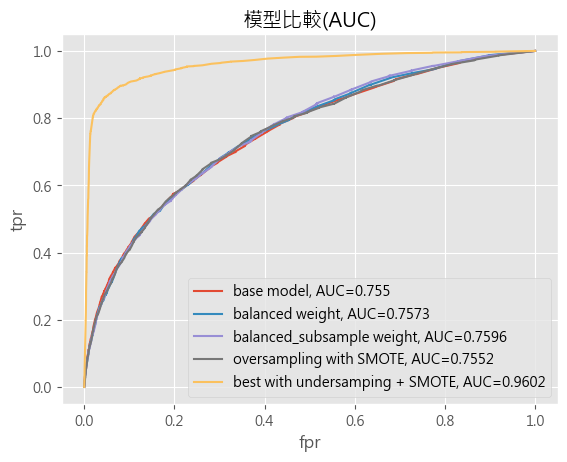

In [17]:
# plot ROC_AUC graph
plt.figure(0).clf()
plt.style.use("ggplot")

plt.plot(fpr1,tpr1,label="base model, AUC="+str(auc1))
plt.plot(fpr2,tpr2,label="balanced weight, AUC="+str(auc2))
plt.plot(fpr3,tpr3,label="balanced_subsample weight, AUC="+str(auc3))
plt.plot(fpr4,tpr4,label="oversampling with SMOTE, AUC="+str(auc4))
plt.plot(fpr5,tpr5,label="best with undersamping + SMOTE, AUC="+str(auc5))

plt.legend(loc=0)
plt.title("模型比較(AUC)")
plt.xlabel("fpr")
plt.ylabel("tpr")

In [18]:
# print out auc mean of scores for each model
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
models = [model1, model2, model3, model4, mm]
k=1
for m in models:
    print("auc score of model%d is %f" % (k, round(np.mean(cross_val_score(m, test_X, test_y, scoring='roc_auc', cv=cv, n_jobs=-1)), 6)))

auc score of model1 is 0.738575
auc score of model1 is 0.738599
auc score of model1 is 0.739002
auc score of model1 is 0.738575
auc score of model1 is nan


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\User\anac